In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import time
import cmath
import sys
import random
from skimage.measure import compare_ssim as ssim

In [2]:
# Loads an RGB image from given path
def loadImage(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) / 255

# Converts RGB image to grayscale
def getGrayscale(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Extracts YUV components from an RGB image
def RGB2YUV(im):
    convMat = np.array([
        [ 0.299,  0.587,  0.114],
        [-0.147, -0.289,  0.436],
        [ 0.615, -0.515, -0.100],
    ])
    compExtr = np.array([
        im[:, :, 0], 
        im[:, :, 1], 
        im[:, :, 2],
    ])

    p, n, m = compExtr.shape
    ret = np.zeros((p, n, m))
    for i in range(p):
        for k in range(p):
            ret[i] += np.multiply(convMat[i][k], compExtr[k])

    return ret[0], ret[1], ret[2]

# Applies guided filter onto 'im' with window-size 'Ws' and smoothing parameter 'e'
def guidedFilter(im, guide, Ws, e):
    imMean = cv2.blur(im, (Ws, Ws))
    guideMean = cv2.blur(guide, (Ws, Ws))
    imVar = cv2.blur(guide ** 2, (Ws, Ws)) - (guideMean ** 2)

    a = cv2.blur(im * guide, (Ws, Ws)) - imMean * guideMean
    a = a / (imVar + e)
    b = imMean - a * guideMean

    aMean = cv2.blur(a, (Ws, Ws))
    bMean = cv2.blur(b, (Ws, Ws))
    
    return (aMean * guide + bMean)

# Finds the window size as specified in the paper
def findWindowSize(im):
    m = np.min(im.shape) // 4
    return m + (1 & ~m)

# Performs local gamma transform given filtered g
def localGammaTransform(im, g):
    return (im) ** ((g + 2) ** (2 * g - 1))

# Stretch range from [A, B] to [A, 1]
def linearStretching(im):
    lMax = np.max(im)
    lMin = np.min(im)
    return ((1 - lMin) * im + (lMax - 1) * lMin) / (lMax - lMin)

# Converts YUV to RGB
def YUV2RGB(im):
    convMat = np.array([
        [ 1.000,  0.000,  1.140],
        [ 1.000, -0.395, -0.581],
        [ 1.000,  2.032,  0.001],
    ])

    p, n, m = im.shape
    ret = np.zeros((p, n, m))
    for i in range(p):
        for k in range(p):
            ret[i] += np.multiply(convMat[i][k], im[k])

    return ret[0], ret[1], ret[2]

# Applies color compensation to ensure consistent saturation of output image
def colorCompensation(channel, Y, newY, e):
    red = np.where(Y == 0.0, channel[0], e * (((newY / Y) * (channel[0] + Y)) + channel[0] - Y))
    blue = np.where(Y == 0.0, channel[1], e * (((newY / Y) * (channel[1] + Y)) + channel[1] - Y))
    green = np.where(Y == 0.0, channel[2], e * (((newY / Y) * (channel[2] + Y)) + channel[2] - Y))
    return red, blue, green

# Clip values of image to be between 0 and 1
def inRange(im):
    return np.minimum(1, np.maximum(im, 0))

<ipython-input-2-849f703dda19>:78: RuntimeWarning: invalid value encountered in true_divide
  red = np.where(Y == 0.0, channel[0], e * (((newY / Y) * (channel[0] + Y)) + channel[0] - Y))
<ipython-input-2-849f703dda19>:79: RuntimeWarning: invalid value encountered in true_divide
  blue = np.where(Y == 0.0, channel[1], e * (((newY / Y) * (channel[1] + Y)) + channel[1] - Y))
<ipython-input-2-849f703dda19>:80: RuntimeWarning: invalid value encountered in true_divide
  green = np.where(Y == 0.0, channel[2], e * (((newY / Y) * (channel[2] + Y)) + channel[2] - Y))


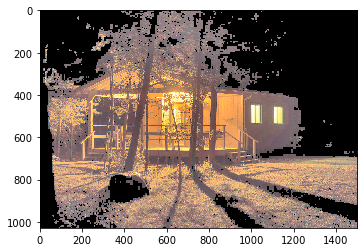

In [3]:
imRGB = loadImage("../temp/1.jpg")
imYUV = RGB2YUV(imRGB)
Y, U, V = imYUV
g = Y.copy()
for i in range(1):
    g = guidedFilter(Y, g, findWindowSize(Y), np.std(g))
gY = localGammaTransform(Y, g)
lY = linearStretching(gY)
RGB = YUV2RGB(np.array([lY, U, V]))
newRGB = colorCompensation(RGB, Y, lY, 0.5)
imNew = cv2.merge(newRGB)
plt.imshow(inRange(imNew))

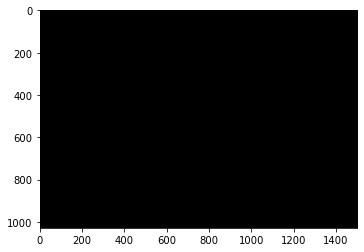

In [18]:
# Subjective Comparison

# Gamma Transform Function for Comparison

def gammaTransform(im, gamma):
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    for i in range(len(im)):
        for j in range(len(im[0])):
            r[i][j] = ((r[i][j]/255)**gamma)*255
            g[i][j] = ((g[i][j]/255)**gamma)*255
            b[i][j] = ((b[i][j]/255)**gamma)*255
    im = cv2.merge((r,g,b))
    return np.uint8(im)


imRGB = loadImage("../temp/1.jpg")
# print(imRGB)
plt.imshow(gammaTransform(imRGB, 1))
# print(imRGB)
# plt.imshow(imRGB)

In [5]:
# Objective Comparison

# Mean Squared Error
def mse(im1, im2):
    mse_val = np.sum((im1.astype("float") - im2.astype("float")) ** 2)
    mse_val /= float(im1.shape[0] * im1.shape[1])
    
#     np.square(np.subtract(im1,im2)).mean()
    
    return mse_val

# Peak Signal-to-Noise Ratio
def psnr(im1, im2):
    mse_val = mse(im1, im2)
    if(mse_val == 0):
        return 100
    
    max_pixel = 255.0
    psnr_val = 20 * np.log10(max_pixel / (np.sqrt(mse_val)))
    return psnr_val
    
# Structural Similarity Index
def ssim(im1, im2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    im1 = im1.astype(np.float64)
    im2 = im2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(im1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(im2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(im1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(im2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(im1 * im2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

IndentationError: expected an indented block (<ipython-input-5-14403d3ca192>, line 14)